In [2]:
from components import *
from modular_network import Network
import mnist_loader, fashion_mnist_loader
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as sci

In [3]:
mnist_train, mnist_val, mnist_test = mnist_loader.load_data_wrapper("../data/mnist.pkl.gz")

In [4]:
# Modify the data for an autoencoder process
for i, tuple_i in enumerate(mnist_train):
    mnist_train[i] = (tuple_i[0], np.reshape(tuple_i[0], (28*28, 1)))

In [12]:
reg = L1Regularization(0.1)

encoder = Network([
    Flatten((28, 28)),
    FullyConnected(28*28, 100, tanh(), None),
    FullyConnected(100, 30, tanh(), None),
])
decoder = Network([
    FullyConnected(30, 100, tanh(), None),
    FullyConnected(100, 28*28, Sigmoid(), None),
])
autoencoder = Network(encoder.layers + decoder.layers)

In [13]:
autoencoder.set_cost(QuadraticCost())
autoencoder.set_optimizer(Adam_optimizer(0.005, 20, 0.99, 0.999))
training_stats = autoencoder.train(mnist_train, 15, 20, monitor_training_cost=True)

Epoch 1 training complete, took 18.264918088912964 seconds
Cost on training data: 14.486807770147088
Epoch 2 training complete, took 18.371796131134033 seconds
Cost on training data: 9.57763319436782
Epoch 3 training complete, took 17.584638833999634 seconds
Cost on training data: 7.583323914735069
Epoch 4 training complete, took 17.454174041748047 seconds
Cost on training data: 6.503567954628195
Epoch 5 training complete, took 17.870198488235474 seconds
Cost on training data: 5.706514226593999
Epoch 6 training complete, took 17.87977433204651 seconds
Cost on training data: 5.2495785283886836
Epoch 7 training complete, took 18.980375051498413 seconds
Cost on training data: 4.83138545085595
Epoch 8 training complete, took 19.01940155029297 seconds
Cost on training data: 4.652277588795372
Epoch 9 training complete, took 17.94689655303955 seconds
Cost on training data: 4.392503667672525
Epoch 10 training complete, took 18.338835954666138 seconds
Cost on training data: 4.261014432183163
Ep

In [77]:
encoder.save("../save/encoder_dim30.json")
decoder.save("../save/decoder_dim30.json")

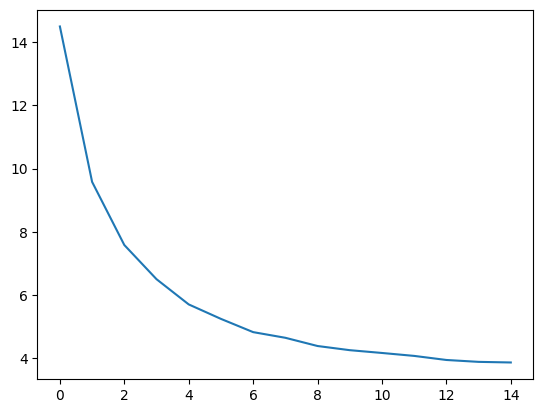

In [14]:
plt.plot(training_stats["training_cost"])

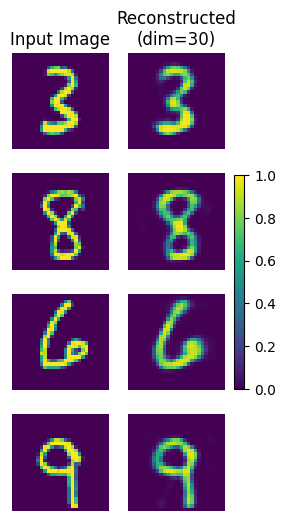

In [78]:
total = 4
square_size = 1.5
fig, axes = plt.subplots(total, 2, figsize=(square_size*2, square_size*total))  # 1 row, 2 columns

vmin = 0
vmax = 1

for test_image_index in range(total):

    test_image = mnist_val[test_image_index][0]
    ae_output = autoencoder.feedforward(np.array([test_image]))
    ae_output = np.reshape(ae_output, (28, 28))

    im1 = axes[test_image_index][0].imshow(test_image, vmin = vmin, vmax = vmax)    
    im2 = axes[test_image_index][1].imshow(ae_output, vmin = vmin, vmax = vmax)

    if test_image_index == 0:
        axes[test_image_index][0].set_title("Input Image")
        axes[test_image_index][1].set_title("Reconstructed\n(dim=30)")

cbar = fig.colorbar(im1, ax=axes, orientation='vertical', fraction=0.046, pad=0.04)

for axarr_1d in axes:
    for ax in axarr_1d:
        ax.axis("off")

plt.show()


In [ ]:
# Let's do some latent space interpolation!
autoencoder.set_mode(Mode.TEST)

In [20]:
def encode(x):
    v = encoder.feedforward(np.array([x]))
    return v.T[0] # column vector --> 1d row vector

def decode(v):
    v = np.array([v]).T # 1d row vector --> column vector
    x = decoder.feedforward(v)
    x = np.reshape(x, (28, 28)) # convert to image shape
    return x

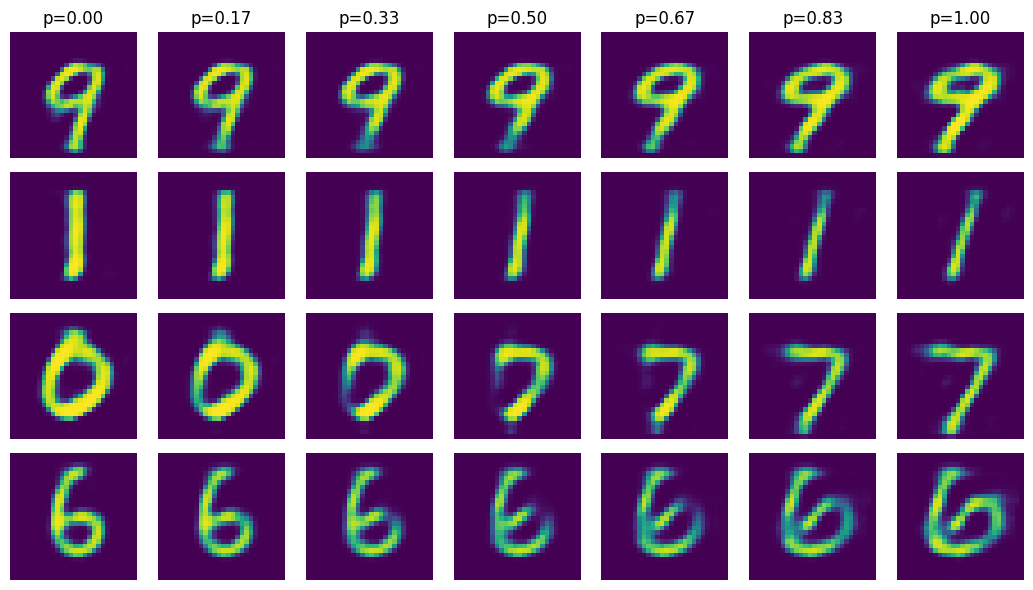

In [129]:
pairs = [(9, 12), (2, 14), (0, 3), (11, 21)]
total = len(pairs)
p_step = 0.1666666
steps = round(1 / p_step + 1)
fig, axes = plt.subplots(total, steps, figsize=(square_size*steps, square_size*total))  # {steps} rows, {total} columns

vmin = 0
vmax = 1

for vertical, pair in enumerate(pairs):
    i0, i1 = pair
    latent0 = encode(mnist_test[i0][0])
    latent1 = encode(mnist_test[i1][0])

    for horizontal in range(steps):
        p = horizontal * p_step
        interp_latent = latent0 * p + latent1 * (1 - p)
        output_img = decode(interp_latent)

        axes[vertical][horizontal].imshow(output_img, vmin = vmin, vmax = vmax)

        if vertical == 0:
            axes[vertical][horizontal].set_title(f"p={p:.2f}")


for axarr_1d in axes:
    for ax in axarr_1d:
        ax.axis("off")

# cbar = fig.colorbar(im1, ax=axes, orientation='vertical', fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()
